In [94]:
from spectral_cube import SpectralCube #To read FITS
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from skimage import measure
from astropy import wcs
import cube_x3d as c3
import matplotlib.pyplot as plt
from matplotlib import cm
from astroquery.skyview import SkyView

In [90]:
import importlib
importlib.reload(c3)

<module 'cube_x3d' from 'c:\\Users\\ixaka\\Documents\\Visualization\\cube_x3d\\cube_x3d.py'>

In [95]:
%cd C:\Users\ixaka\Documents\Visualization

C:\Users\ixaka\Documents\Visualization


In [96]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx

In [97]:
# Read the fits file and save header
cube = SpectralCube.read('C:\\Users\\ixaka\\Documents\\Optical-Montoro\\flux_MRB_final_rss_subCube.fits')
cubehead = cube.header
cubew = wcs.WCS(cubehead)
nz, ny, nx = cube.shape
print(cube.shape)
dra, ddec, dv = cubehead['CDELT1'], cubehead['CDELT2'], cubehead['CDELT3']
delta_arcsec = (np.abs(dra)*3600, np.abs(ddec)*3600, np.abs(dv))

(682, 52, 58)


In [98]:
mask = SpectralCube.read('C:\\Users\\ixaka\\Documents\\Optical-Montoro\\flux_MRB_final_rss_subCube-mask.fits')
mask.shape

(682, 52, 58)

In [11]:
#because the mask is for the full cube and we upload only the subcube, we need to cut the mask
minl = np.where(mask.spectral_axis == cube.spectral_axis[0])[0][0]
maxl = np.where(mask.spectral_axis == cube.spectral_axis[-1])[0][0]
print(mask.spectral_axis[[minl,maxl+1]])
print(cube.spectral_axis[[0,-1]])
mask = mask.unmasked_data[minl:maxl+1]

[] Angstrom
[4568.11 5041.  ] Angstrom


In [99]:
#half width of wanted wavelength axis
hw = 80

In [100]:
#borja MRB
# Limits to crop the cube, no HI there. Subtract 1 to wanted number, e.g. nz-1.
limx = [0, nx-1]
limy = [0, ny-1]
#limz = [3450, 4100-1]
limz = [0,hw*2-1]

In [101]:
# The CRVAL1/2 values in the cubes of borja are wrong, must calculate axis using 'RADEG', 'DECDEG' 
ralim = [cubehead['RADEG']+dra, cubehead['RADEG']+(1+nx)*dra][::int(np.sign(cubehead["CDELT1"]))]
ramean = np.mean(ralim)
declim = [cubehead['DECDEG']+ddec, cubehead['DECDEG']+(1+ny)*ddec][::int(np.sign(cubehead["CDELT2"]))]
decmean = np.mean(declim)
vlim = cube.spectral_axis[limz][::int(np.sign(dv))]
vmean = np.mean(vlim).to('angstrom').to_value()

In [102]:
print(ralim,'--',ramean)
print(declim,'--',decmean)
print(vlim)

[289.5814658592234, 289.58491867043324] -- 289.5831922648283
[1.7832825014824156, 1.7863793903713046] -- 1.78483094592686
[4945.63 4963.12] Angstrom


In [9]:
ralim = cube.spatial_coordinate_map[1][0,:][limx][::int(np.sign(cubehead["CDELT1"]))]
ramean = np.mean(ralim)
declim = cube.spatial_coordinate_map[0][:,0][limy][::int(np.sign(cubehead["CDELT2"]))]
decmean = np.mean(declim)
vlim = cube.spectral_axis[limz][::int(np.sign(dv))]
vmean = np.mean(vlim).to('angstrom').to_value()

In [103]:
line1 = 5006.843 #OIII 1
line1 = find_nearest(cube.spectral_axis, line1)

In [104]:
# with mask
cube = cube.unmasked_data[:] * mask.unmasked_data[:]/np.max(mask.unmasked_data[:])

4363 linea para MRUB

In [10]:
# without mask
cube = cube.unmasked_data[:]

In [105]:
# create cropped array and transform units to mJy/beam
HI_cube = cube[:,limy[0]:limy[1]+1,limx[0]:limx[1]+1].to_value() *10**17 #*10**17 for HRR and *10**16 for MRB
# Slice the data, transpose to (ra,dec,v) and flip axes if needed (see if step in FITS header is + or -)
HI_cube = c3.transpose(HI_cube, (dra,ddec,dv))

In [106]:
#MRB
cube1 = HI_cube[:,:,line1[1]-hw:line1[1]+hw]

In [107]:
# Read the fits file and save header
cube = SpectralCube.read('C:\\Users\\ixaka\\Documents\\Optical-Montoro\\flux_HRR_final_rss_corr.fits')
cubehead = cube.header
cubew = wcs.WCS(cubehead)
nz, ny, nx = cube.shape
print(cube.shape)
dra, ddec, dv = cubehead['CDELT1'], cubehead['CDELT2'], cubehead['CDELT3']
delta_arcsec = (np.abs(dra)*3600, np.abs(ddec)*3600, np.abs(dv))

(4300, 52, 58)


In [108]:
mask = SpectralCube.read('C:\\Users\\ixaka\\Documents\\Optical-Montoro\\flux_HRR_final_rss-mask.fits')
mask.shape

(4300, 52, 58)

In [16]:
#because the mask is for the full cube and we upload only the subcube, we need to cut the mask
minl = np.where(mask.spectral_axis == cube.spectral_axis[0])[0][0]
maxl = np.where(mask.spectral_axis == cube.spectral_axis[-1])[0][0]
print(mask.spectral_axis[[minl,maxl+1]])
print(cube.spectral_axis[[0,-1]])
mask = mask.unmasked_data[minl:maxl+1]

IndexError: index 4300 is out of bounds for axis 0 with size 4300

In [109]:
#borja HRR
limx = [0, nx-1]
limy = [0, ny-1]
#limz = [1520, 2100-1] #also 4300-2200
limz = [0,hw*2-1]

In [110]:
# The CRVAL1/2 values in the cubes of borja are wrong, must calculate axis using 'RADEG', 'DECDEG' 
ralim = [cubehead['RADEG']+dra, cubehead['RADEG']+(1+nx)*dra][::int(np.sign(cubehead["CDELT1"]))]
ramean = np.mean(ralim)
declim = [cubehead['DECDEG']+ddec, cubehead['DECDEG']+(1+ny)*ddec][::int(np.sign(cubehead["CDELT2"]))]
decmean = np.mean(declim)
vlim = cube.spectral_axis[limz][::int(np.sign(dv))]
vmean = np.mean(vlim).to('angstrom').to_value()

In [111]:
print(ralim,'--',ramean)
print(declim,'--',decmean)
print(vlim)

[289.5838209575624, 289.58727376877226] -- 289.58554736316734
[1.7815651055555557, 1.7846619944444446] -- 1.7831135500000002
[6390.0974 6405.584 ] Angstrom


In [17]:
ralim = cube.spatial_coordinate_map[1][0,:][limx][::int(np.sign(cubehead["CDELT1"]))]
ramean = np.mean(ralim)
declim = cube.spatial_coordinate_map[0][:,0][limy][::int(np.sign(cubehead["CDELT2"]))]
decmean = np.mean(declim)
vlim = cube.spectral_axis[limz][::int(np.sign(dv))]
vmean = np.mean(vlim).to('angstrom').to_value()

In [112]:
line2 = 6583.45 #NII 2
line2 = find_nearest(cube.spectral_axis, line2)
line3 = 6562.05 #Halpha
line3 = find_nearest(cube.spectral_axis, line3)

In [113]:
# with mask
cube = cube.unmasked_data[:] * mask.unmasked_data[:]/np.max(mask.unmasked_data[:])

In [18]:
# without mask
cube = cube.unmasked_data[:]

In [114]:
# create cropped array and transform units to mJy/beam
HI_cube = cube[:,limy[0]:limy[1]+1,limx[0]:limx[1]+1].to_value()*10**17
# Slice the data, transpose to (ra,dec,v) and flip axes if needed (see if step in FITS header is + or -)
HI_cube = c3.transpose(HI_cube, (dra,ddec,dv))

In [115]:
#HRR
cube2 = HI_cube[:,:,line2[1]-hw:line2[1]+hw]
cube3 = HI_cube[:,:,line3[1]-hw:line3[1]+hw]

In [116]:
cubes = [cube1, cube2, cube3]

In [117]:
shifts = [[0,0,0],[0.8895*dra*3600, 1.8222*ddec*3600, 0],[0.8895*dra*3600, 1.8222*ddec*3600, 0]]
shifts

[[0, 0, 0],
 [-0.19063089752167536, 0.39067967999999637, 0],
 [-0.19063089752167536, 0.39067967999999637, 0]]

tomamos como fija la del oxigeno:

shift en nitrogeno<br>
coordenada x 0.8895 coordenada y 1.8222<br>

sistema de referencia local standard of rest

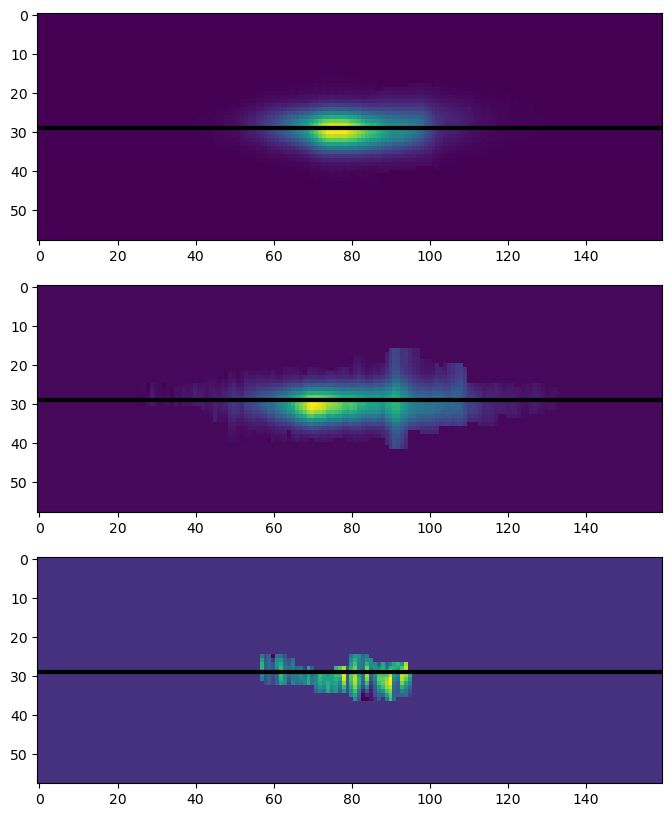

In [118]:
fig, ax = plt.subplots(nrows=3,figsize=(16,10))
ax[0].imshow(cube1[:,26,:])
#ax[0].axvline(line1[1],color='r', label=line1[1])
#ax[0].set_xlim(3480,3630)
#ax[0].set_xlim(100,150)
#ax[0].set_ylim(25,35)
#ax[0].legend()
ax[0].axhline(nx/2,color='k', lw=3)
ax[1].imshow(cube2[:,26,:])
#ax[1].set_xlim(3920,4070)
#ax[1].set_xlim(100,150)
#ax[1].set_ylim(25,35)
#ax[1].axvline(line2[1],color='r', label=line2[1])
#ax[1].legend()
ax[1].axhline(nx/2,color='k',lw=3)
ax[2].imshow(cube3[:,26,:])
#ax[2].set_xlim(3920,4070)
#ax[2].set_xlim(100,150)
#ax[2].set_ylim(25,35)
#ax[2].axvline(line2[1],color='r', label=line2[1])
#ax[2].legend()
ax[2].axhline(nx/2,color='k',lw=3)


In [ ]:
# from astropy.io import fits

# with fits.open('C:\\Users\\ixaka\\Documents\\Optical-Montoro\\flux_HRR_final_rss-mask.fits', mode='update') as hdul:
#     hdul[0].data[1781:1820,:,:] = 0
#     hdul.flush()

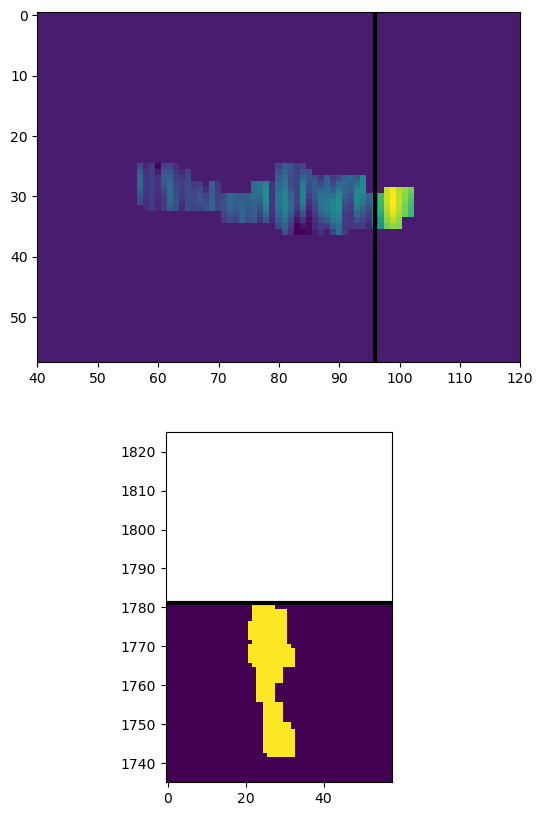

In [92]:
fig, ax = plt.subplots(nrows=2,figsize=(16,10))
ax[0].imshow(cube3[:,26,:], norm='asinh')
#ax[0].axvline(line1[1],color='r', label=line1[1])
#ax[0].set_xlim(3480,3630)
ax[0].set_xlim(40,120)
#ax[0].set_ylim(25,35)
#ax[0].legend()
#ax[0].axhline(nx/2,color='k', lw=3)
ax[0].axvline(96,color='k',lw=3)
ax[1].imshow(mask.unmasked_data[:][:1781,26,:])
#ax[1].set_xlim(3920,4070)
#ax[1].set_xlim(100,150)
ax[1].set_ylim(line3[1]-hw+50,line3[1]+hw-20)
#ax[1].axvline(line2[1],color='r', label=line2[1])
#ax[1].legend()
ax[1].axhline(nx/2,color='k',lw=3)
ax[1].axhline(1781,color='k',lw=3)

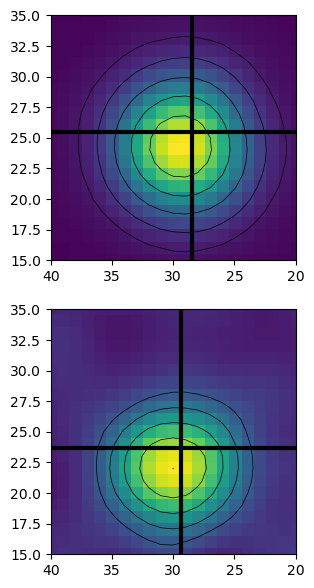

In [30]:
fig, ax = plt.subplots(nrows=2,figsize=(16,7))
ax[0].imshow(cube1[:,:,120].T, norm='linear')
#ax[0].axvline(line1[1],color='r', label=line1[1])
ax[0].set_xlim(40,20)
ax[0].set_ylim(15,35)
ax[0].contour(cube1[:,:,120].T, levels=isolevels1, colors='k', linewidths=0.5)
#ax[0].legend()
ax[0].axhline(ny/2-.5,color='k', lw=3)
ax[0].axvline(nx/2-.5,color='k', lw=3)
ax[1].imshow(cube2[:,:,120].T)
ax[1].set_xlim(40,20)
ax[1].set_ylim(15,35)
#ax[1].axvline(line2[1],color='r', label=line2[1])
#ax[1].legend()
ax[1].axhline(ny/2-.5-1.8222,color='k',lw=3)
ax[1].axvline(nx/2-.5+0.8895,color='k',lw=3)
ax[1].contour(cube2[:,:,120].T, levels=isolevels2, colors='k', linewidths=0.5)

To overlay both lines we need to create two small cubes of the same size where the lines can be found at (approximately) the same position.

(0.0, 3.1704442181752697)

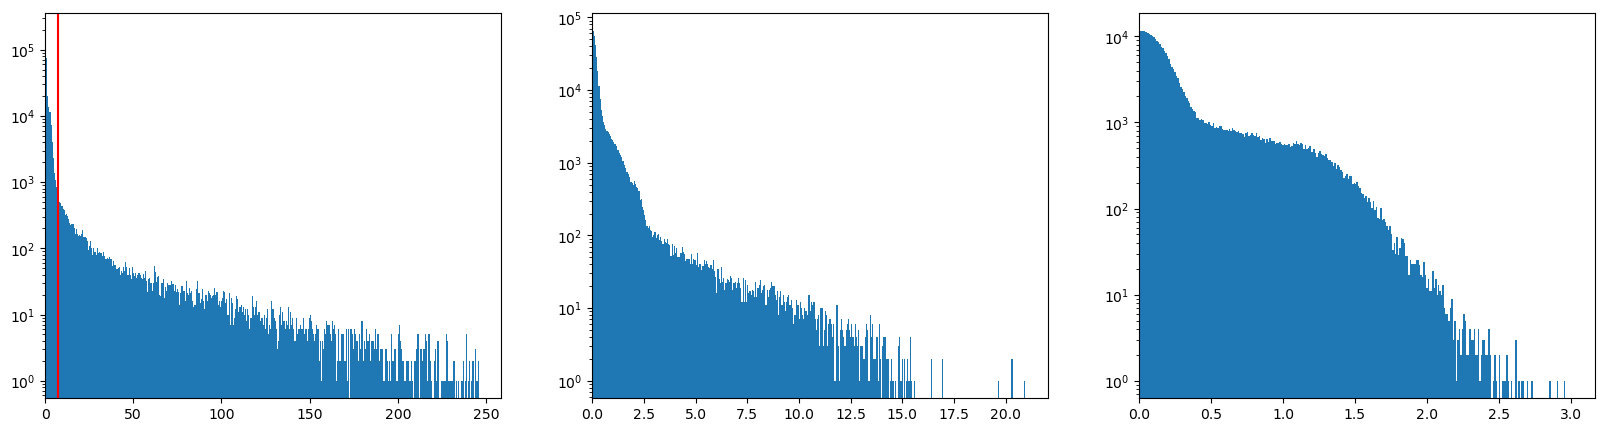

In [23]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
ax[0].hist(cube1.flatten(), bins=400)
ax[0].set_yscale('log')
ax[0].set_xlim(0,)
ax[0].axvline(7.5, c='r')
ax[1].hist(cube2.flatten(), bins=400)
ax[1].set_yscale('log')
ax[1].set_xlim(0,)
ax[2].hist(cube3.flatten(), bins=400)
ax[2].set_yscale('log')
ax[2].set_xlim(0,)

Tiene sentido que en Halpha desaparezcan valores altos con la mascara porque la nebulosa es más intensa.

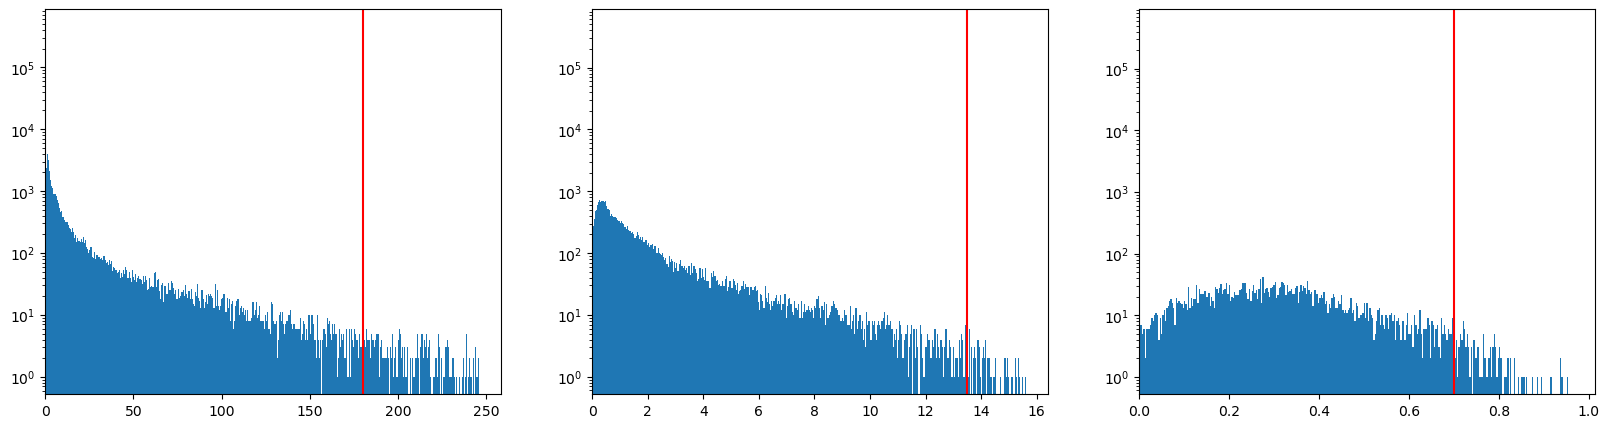

In [123]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
ax[0].hist(cube1.flatten(), bins=400)
ax[0].set_yscale('log')
ax[0].set_xlim(0,)
ax[0].axvline(180, c='r')
ax[1].hist(cube2.flatten(), bins=400)
ax[1].set_yscale('log')
ax[1].set_xlim(0,)
ax[1].axvline(13.5, c='r')
ax[2].hist(cube3.flatten(), bins=400)
ax[2].set_yscale('log')
ax[2].set_xlim(0,)
ax[2].axvline(0.7, c='r')

In [80]:
#para las primeras lineas
isolevels1 = np.array([0.45, 1.1, 2.3, 4, 6])*10 #*10 because isolevels were written considering *10**17 instead of *10**16
isolevels2 = np.array([0.7, 1.3, 2.1, 3, 4])
isolevels3 = np.array([0.2, 0.35, 0.55, 0.7])
isolevels = [isolevels1, isolevels2, isolevels3]

In [124]:
#para las segundas lineas
isolevels1 = np.array([2.5, 8, 13, 18, 21.5])*10 #*10 because isolevels were written considering *10**17 instead of *10**16
isolevels2 = np.array([2.5, 5, 7.5, 10, 12.5])
isolevels3 = np.array([0.2, 0.35, 0.55, 0.7])
isolevels = [isolevels1, isolevels2, isolevels3]

In [125]:
coords = np.array([ralim, declim, vlim])
coords

array([[2.89583821e+02, 2.89587274e+02],
       [1.78156511e+00, 1.78466199e+00],
       [6.39009740e+03, 6.40558400e+03]])

In [126]:
color1 = c3.create_colormap('Greens', isolevels1, start=255/2.5) # Oxigen
color2 = c3.create_colormap('Blues', isolevels2, start=255/2.5) # Nitrogen
color3 = c3.create_colormap('Reds', isolevels3, start=255/2.5) # Hydrogen
colors = [color1, color2, color3]

In [127]:
meta = {'generator':'create_x3d python module',
       'creator':'Name Surname',
       'title':cubehead['OBJECT'],
        'numberofelements':f'{len(isolevels)} layers',
        'description':'data cube of %s'%cubehead['OBJECT']
       }

In [128]:
x3dname = 'OIII_1-NII_1_corr_mask.x3d'

In [129]:
file = c3.write_x3d('./cube_x3d/examples/%s'%x3dname, delta_arcsec,
                    coords, header=cubehead, units=["e17 "+cubehead["BUNIT"], 'arcsec', 'arcsec', 'angstrom'], meta=meta, picking=False)

#also need html.func_pick() if picking=True

[[-6.21205591  0.          6.21205591]
 [-5.5744      0.          5.5744    ]
 [-7.7433      0.          7.7433    ]]


In [130]:
file.make_layers(cubes, isolevels, colors, shifts=shifts)
file.make_outline()
#file.make_galaxies(gals=gals, labels=True)
#file.make_image2d(imcol=None, img_shape=None)
file.make_ticklines()
file.make_labels(gals=None, axlab='diff') 
#html.func_scalev(axes) should be same as axlab, not func_axes() though.
file.close()

In [131]:
tabtitle = f'{cubehead["OBJECT"]}'
pagetitle = f'3D interactive datacube: {cubehead["OBJECT"]}'
# add in desc for 2d image: <br>\n\t Background image: {survey}
desc = f"Object: {cubehead['OBJECT']}.<t> Telescope: {cubehead['TELESCOP']}, Instrument: {cubehead['INSTRUME']}, Obsmode: {cubehead['OBSMODE']}.<br>\n\t Center: (RA,DEC)=({np.round(ramean,5)}, {np.round(decmean,5)}). Date-obs: {cubehead['DATE-OBS']}"

In [132]:
colmaps = ['Greens', 'Reds', 'magma', 'CMRmap', 'inferno', 'plasma', 'viridis', 'Greys',
           'Blues', 'OrRd', 'PuRd', 'Reds', 'Spectral', 'Wistia',
          'YlGn', 'YlOrRd', 'afmhot', 'autumn', 'cool', 'coolwarm',
          'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_heat',
          'gist_ncar', 'gist_stern', 'gnuplot', 'gnuplot2', 'hot',
          'nipy_spectral', 'prism', 'winter', 'Paired']

In [74]:
import importlib
importlib.reload(c3)

<module 'cube_x3d' from 'c:\\Users\\ixaka\\Documents\\Visualization\\cube_x3d\\cube_x3d.py'>

In [133]:
html = c3.write_html('./cube_x3d/examples/%s.html'%x3dname.split('.')[0], 
                    units=["e17 "+cubehead["BUNIT"], 'arcsec', 'arcsec', 'angstrom'], l_isolevels=isolevels,
                     tabtitle=tabtitle, pagetitle=pagetitle,
                     description=desc)

In [134]:
html.func_layers(isolevels)
#html.func_galaxies(gals)
#html.func_gallab()
html.func_grids()
html.func_axes('diff')
#html.func_pick() #for coordinate picking
html.start_x3d()
html.viewpoints(maxcoord=file.diff_coords[:,2])
html.close_x3d(x3dname)
html.buttons(isolevels, colors, colormaps=colmaps, hide2d=False, scalev=True, move2d=False, lineLabs=[r'OIII ($5006.843 \, \mathring{A}$)', r'NII ($6583.45 \, \mathring{A}$)', r'H$\alpha$ ($6562.8 \, \mathring{A}$)'])
#func_move2dimage, func_setCenterOfRotation, func_colormaps and func_scalev must always go after buttons
#html.func_image2d()
#html.func_setCenterOfRotation(['0 0 -19', '0 0 -4','0 0 17.5']) #['0 0 -29.3', '0 0 19.1'] for MRB
html.func_colormaps(isolevels)
html.func_scalev(gals=None, axes='diff', coords=file.diff_coords, move2d=False) #file.diff_coords[2,2]
#html.func_move2dimage(real_vmax=file.real_coords[2,2], diff_vmax=file.diff_coords[2,2])
html.close_html()